In [1]:
import ete3
import treeCl
import os
import re
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.manifold import MDS
import plotly
import plotly.plotly as ptl
from plotly import graph_objs as go
ptl.sign_in('lthiberiol', 'm15ikp59lt')

%cd /work/nif/tree_dist

DEBUG:matplotlib:CACHEDIR=/Users/thiberio/.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /Users/thiberio/.matplotlib/fontList.json
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


/work/nif/tree_dist


In [4]:
nif_genes = pd.read_table('../nif_gene_names.tab', comment='#', index_col=0)
vertical_genes = 'L1 L11 L13 L14 L16 L17 L18 L19 L2 L20 L22 L24 L27\
                  L4 L5 L6 L9 S1 S10 S11 S12 S13 S15 S16 S17 S18\
                  S19 S2 S3 S4 S5 S7 S8 S9'.split()
groups = 'Proteo_1010 Proteo_1596 Proteo_1952 Proteo_2186 Proteo_2312 Proteo_2513 Proteo_2778\
          Proteo_3012 Proteo_3479 Proteo_4355 Proteo_4806 Proteo_603  Proteo_8392 Proteo_1034\
          Proteo_1639 Proteo_1984 Proteo_2206 Proteo_2313 Proteo_2521 Proteo_2814 Proteo_3115\
          Proteo_3535 Proteo_4431 Proteo_4977 Proteo_617  Proteo_865  Proteo_1058 Proteo_1698\
          Proteo_2005 Proteo_2218 Proteo_2336 Proteo_2542 Proteo_2831 Proteo_3117 Proteo_3572\
          Proteo_4530 Proteo_5209 Proteo_6176 Proteo_9216 Proteo_106  Proteo_1760 Proteo_2006\
          Proteo_2225 Proteo_2341 Proteo_2557 Proteo_2842 Proteo_3155 Proteo_3636 Proteo_454 \
          Proteo_53   Proteo_640  Proteo_9507 Proteo_1157 Proteo_1764 Proteo_2080 Proteo_2230\
          Proteo_2373 Proteo_2644 Proteo_2863 Proteo_3255 Proteo_387  Proteo_4593 Proteo_5463\
          Proteo_652  Proteo_1245 Proteo_1771 Proteo_2081 Proteo_2245 Proteo_2394 Proteo_2688\
          Proteo_2885 Proteo_3312 Proteo_3901 Proteo_4657 Proteo_578  Proteo_72   Proteo_1514\
          Proteo_180  Proteo_2131 Proteo_2246 Proteo_2396 Proteo_2717 Proteo_2906 Proteo_3317\
          Proteo_3903 Proteo_4693 Proteo_5917 Proteo_7746 Proteo_1530 Proteo_1899 Proteo_2166\
          Proteo_2264 Proteo_2457 Proteo_2771 Proteo_3004 Proteo_3442 Proteo_410  Proteo_478 \
          Proteo_5918 Proteo_7809'.split()

proteo = pd.read_table('/work/nif/proteo_info.tab', index_col=0)

In [ ]:
def prepare_data(group):
    alignment        = open('/work/nif/control_reconciliations/%s/%s.aln' % (group, group)).read()
    all_taxa         = re.findall('^>(\S+)', alignment, re.M)
    all_genomes      = re.findall('^>(\S+?)\|', alignment, re.M)
    alignment_blocks = alignment.split('>') # split multiFASTA into single blocks using the ">" header starter
    alignment_blocks.pop(0) # since the file starts with a ">" the first element will always be empty

    #
    # create file with a treeCl-happy extension: ".fas"
    out = open('/work/nif/tree_dist/alignments/%s.fas' % group, 'wb')
    for block in alignment_blocks:
        block    = block.split('\n')    #separate header (only element before linebreak) from sequence (everything else)
        header   = block[0].split('|')[0]   #use only the GENOME part from the header (GENOME|GENE)
        if all_genomes.count(header) != 1:
            continue
        sequence = '\n'.join(block[1:])
        out.write('>%s\n%s' %(proteo.loc[re.sub('[.-]', '', header), 'taxid'], sequence))
    out.close()

    tree_text   = open('/work/nif/control_reconciliations/%s/%s.aln.treefile' % (group, group)).read()
    for taxa in all_taxa:
        tree_text = tree_text.replace(taxa.replace('|', '_'), taxa)
    tree        = ete3.Tree(tree_text, format=1)
    single_copies = []
    for leaf in tree.get_leaves():
        genome = leaf.name.split('|')[0]
        if all_genomes.count(genome) != 1:
            continue
        leaf.name = str(proteo.loc[re.sub('[.-]', '', genome), 'taxid'])
        single_copies.append(leaf.name)

    tree.prune(single_copies, preserve_branch_length=True)
    tree.write(outfile='/work/nif/tree_dist/trees/%s.nwk' %group,
               format=5, dist_formatter='%.20f')

for group in groups:
    prepare_data(group)

In [ ]:
def prepare_data(group):
    alignment        = open('/work/nif/tree_data/%s/MSA.MAFFT.Without_low_SP_Col.With_Names' % group).read()
    all_taxa         = re.findall('^>(\S+)', alignment, re.M)
    all_genomes      = re.findall('^>(\S+?)\|', alignment, re.M)
    alignment_blocks = alignment.split('>') # split multiFASTA into single blocks using the ">" header starter
    alignment_blocks.pop(0) # since the file starts with a ">" the first element will always be empty

    #
    # create file with a treeCl-happy extension: ".fas"
    out = open('/work/nif/tree_dist/alignments/%s.fas' % group, 'wb')
    for block in alignment_blocks:
        block    = block.split('\n')    #separate header (only element before linebreak) from sequence (everything else)
        header   = block[0].split('|')[0]   #use only the GENOME part from the header (GENOME|GENE)
        if all_genomes.count(header) != 1:
            continue
        sequence = '\n'.join(block[1:])
        out.write('>%s\n%s' %(proteo.loc[re.sub('[.-]', '', header), 'taxid'], sequence))
    out.close()

    tree        = ete3.Tree('/work/nif/tree_data/%s/RAxML_bestTree.step1' % group)
    single_copies = []
    for leaf in tree.get_leaves():
        genome = leaf.name.split('|')[0]
        if all_genomes.count(genome) != 1:
            continue
        leaf.name = str(proteo.loc[re.sub('[.-]', '', genome), 'taxid'])
        single_copies.append(leaf.name)

    tree.prune(single_copies, preserve_branch_length=True)
    tree.write(outfile='/work/nif/tree_dist/trees/%s.nwk' %group,
               format=5, dist_formatter='%.20f')

for group in nif_genes.group.values:
    if (not os.path.isdir('../tree_data/%s' % group) or
        not os.path.isfile('/work/nif/tree_data/%s/MSA.MAFFT.Without_low_SP_Col.With_Names' % group) or
        not os.path.isfile('/work/nif/tree_data/%s/RAxML_bestTree.step1' % group)
       ):
        print '%s not found!' % group
    else:
        prepare_data(group)

In [ ]:
def prepare_data(group):
    alignment        = open('/work/nif/ramulu_gene_families/%s.fasta.guidance/MSA.MAFFT.Without_low_SP_Col.With_Names' % group).read()
    all_taxa         = re.findall('^>(\S+)', alignment, re.M)
    all_genomes      = re.findall('^>(\S+?)\|', alignment, re.M)
    alignment_blocks = alignment.split('>') # split multiFASTA into single blocks using the ">" header starter
    alignment_blocks.pop(0) # since the file starts with a ">" the first element will always be empty

    #
    # create file with a treeCl-happy extension: ".fas"
    out = open('/work/nif/tree_dist/alignments/%s.fas' % group, 'wb')
    for block in alignment_blocks:
        block    = block.split('\n')    #separate header (only element before linebreak) from sequence (everything else)
        header   = block[0].split('|')[0]   #use only the GENOME part from the header (GENOME|GENE)
        if all_genomes.count(header) != 1:
            continue
        sequence = '\n'.join(block[1:])
        out.write('>%s\n%s' %(proteo.loc[re.sub('[.-]', '', header), 'taxid'], sequence))
    out.close()

    tree        = ete3.Tree('/work/nif/ramulu_gene_families/%s.fasta.guidance.tre' % group)
    single_copies = []
    for leaf in tree.get_leaves():
        genome = leaf.name.split('|')[0]
        if all_genomes.count(genome) != 1:
            continue
        leaf.name = str(proteo.loc[re.sub('[.-]', '', genome), 'taxid'])
        single_copies.append(leaf.name)

    tree.prune(single_copies, preserve_branch_length=True)
    tree.write(outfile='/work/nif/tree_dist/trees/%s.nwk' %group,
               format=5, dist_formatter='%.20f')

for group in vertical_genes:
    print group
    prepare_data(group)

In [18]:
def prepare_data(aln_file, tree_file, output_pre):
    alignment        = open(aln_file).read()
    all_taxa         = re.findall('^>(\S+)', alignment, re.M)
    alignment_blocks = alignment.split('>') # split multiFASTA into single blocks using the ">" header starter
    alignment_blocks.pop(0) # since the file starts with a ">" the first element will always be empty

    #
    # create file with a treeCl-happy extension: ".fas"
    out = open('/work/nif/tree_dist/alignments/%s.fas' % output_pre, 'wb')
    for block in alignment_blocks:
        block    = block.split('\n')    #separate header (only element before linebreak) from sequence (everything else)
        header   = block[0]   #use only the GENOME part from the header (GENOME|GENE)
        sequence = '\n'.join(block[1:])
        out.write('>%s\n%s' %(proteo.loc[re.sub('[.-]', '', header), 'taxid'], sequence))
    out.close()

    tree        = ete3.Tree(tree_file, format=1)
    single_copies = []
    for leaf in tree.get_leaves():
        genome = leaf.name
        leaf.name = str(proteo.loc[re.sub('[.-]', '', genome), 'taxid'])
        single_copies.append(leaf.name)

    tree.write(outfile='/work/nif/tree_dist/trees/%s.nwk' %output_pre,
               format=5, dist_formatter='%.20f')

In [19]:
prepare_data('../ramulu_gene_families/all_ref_genes_concat.aln', 
             '../ramulu_gene_families/RAxML_fastTreeSH_Support.all_ref_genes_concat-support2',
             'species')
prepare_data('../nifHDKENB_concat/concatenated_alignment.aln', 
             '../nifHDKENB_concat/concatenated_partitions.treefile',
             'nifHDKENB')

In [20]:
tree_data = treeCl.Collection(input_dir='alignments', file_format='fasta', trees_dir='trees')
#tree_data.read_trees(input_dir='trees')

Loading files: 181 of 181 |###############| Elapsed Time: 0:00:12 Time: 0:00:12
Loading trees: 100% |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


In [ ]:
processes = treeCl.parutils.ProcesspoolJobHandler(15)  # with pure python code, it is better to use processpools to parallelise for speed
distance_matrix = tree_data.get_inter_tree_distances('geo',
                                                     jobhandler=processes,
                                                     batchsize=100)  # jobs are done in batches to reduce overhead

df = pd.DataFrame(data=distance_matrix.values,
                  index=distance_matrix.get_names(),
                  columns=distance_matrix.get_names())

In [22]:
df.to_csv('geodesic_distances.csv')

In [ ]:
df = pd.read_csv('geodesic_distances.csv', index_col=0)

/Users/thiberio/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:823: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike

/Users/thiberio/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:825: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



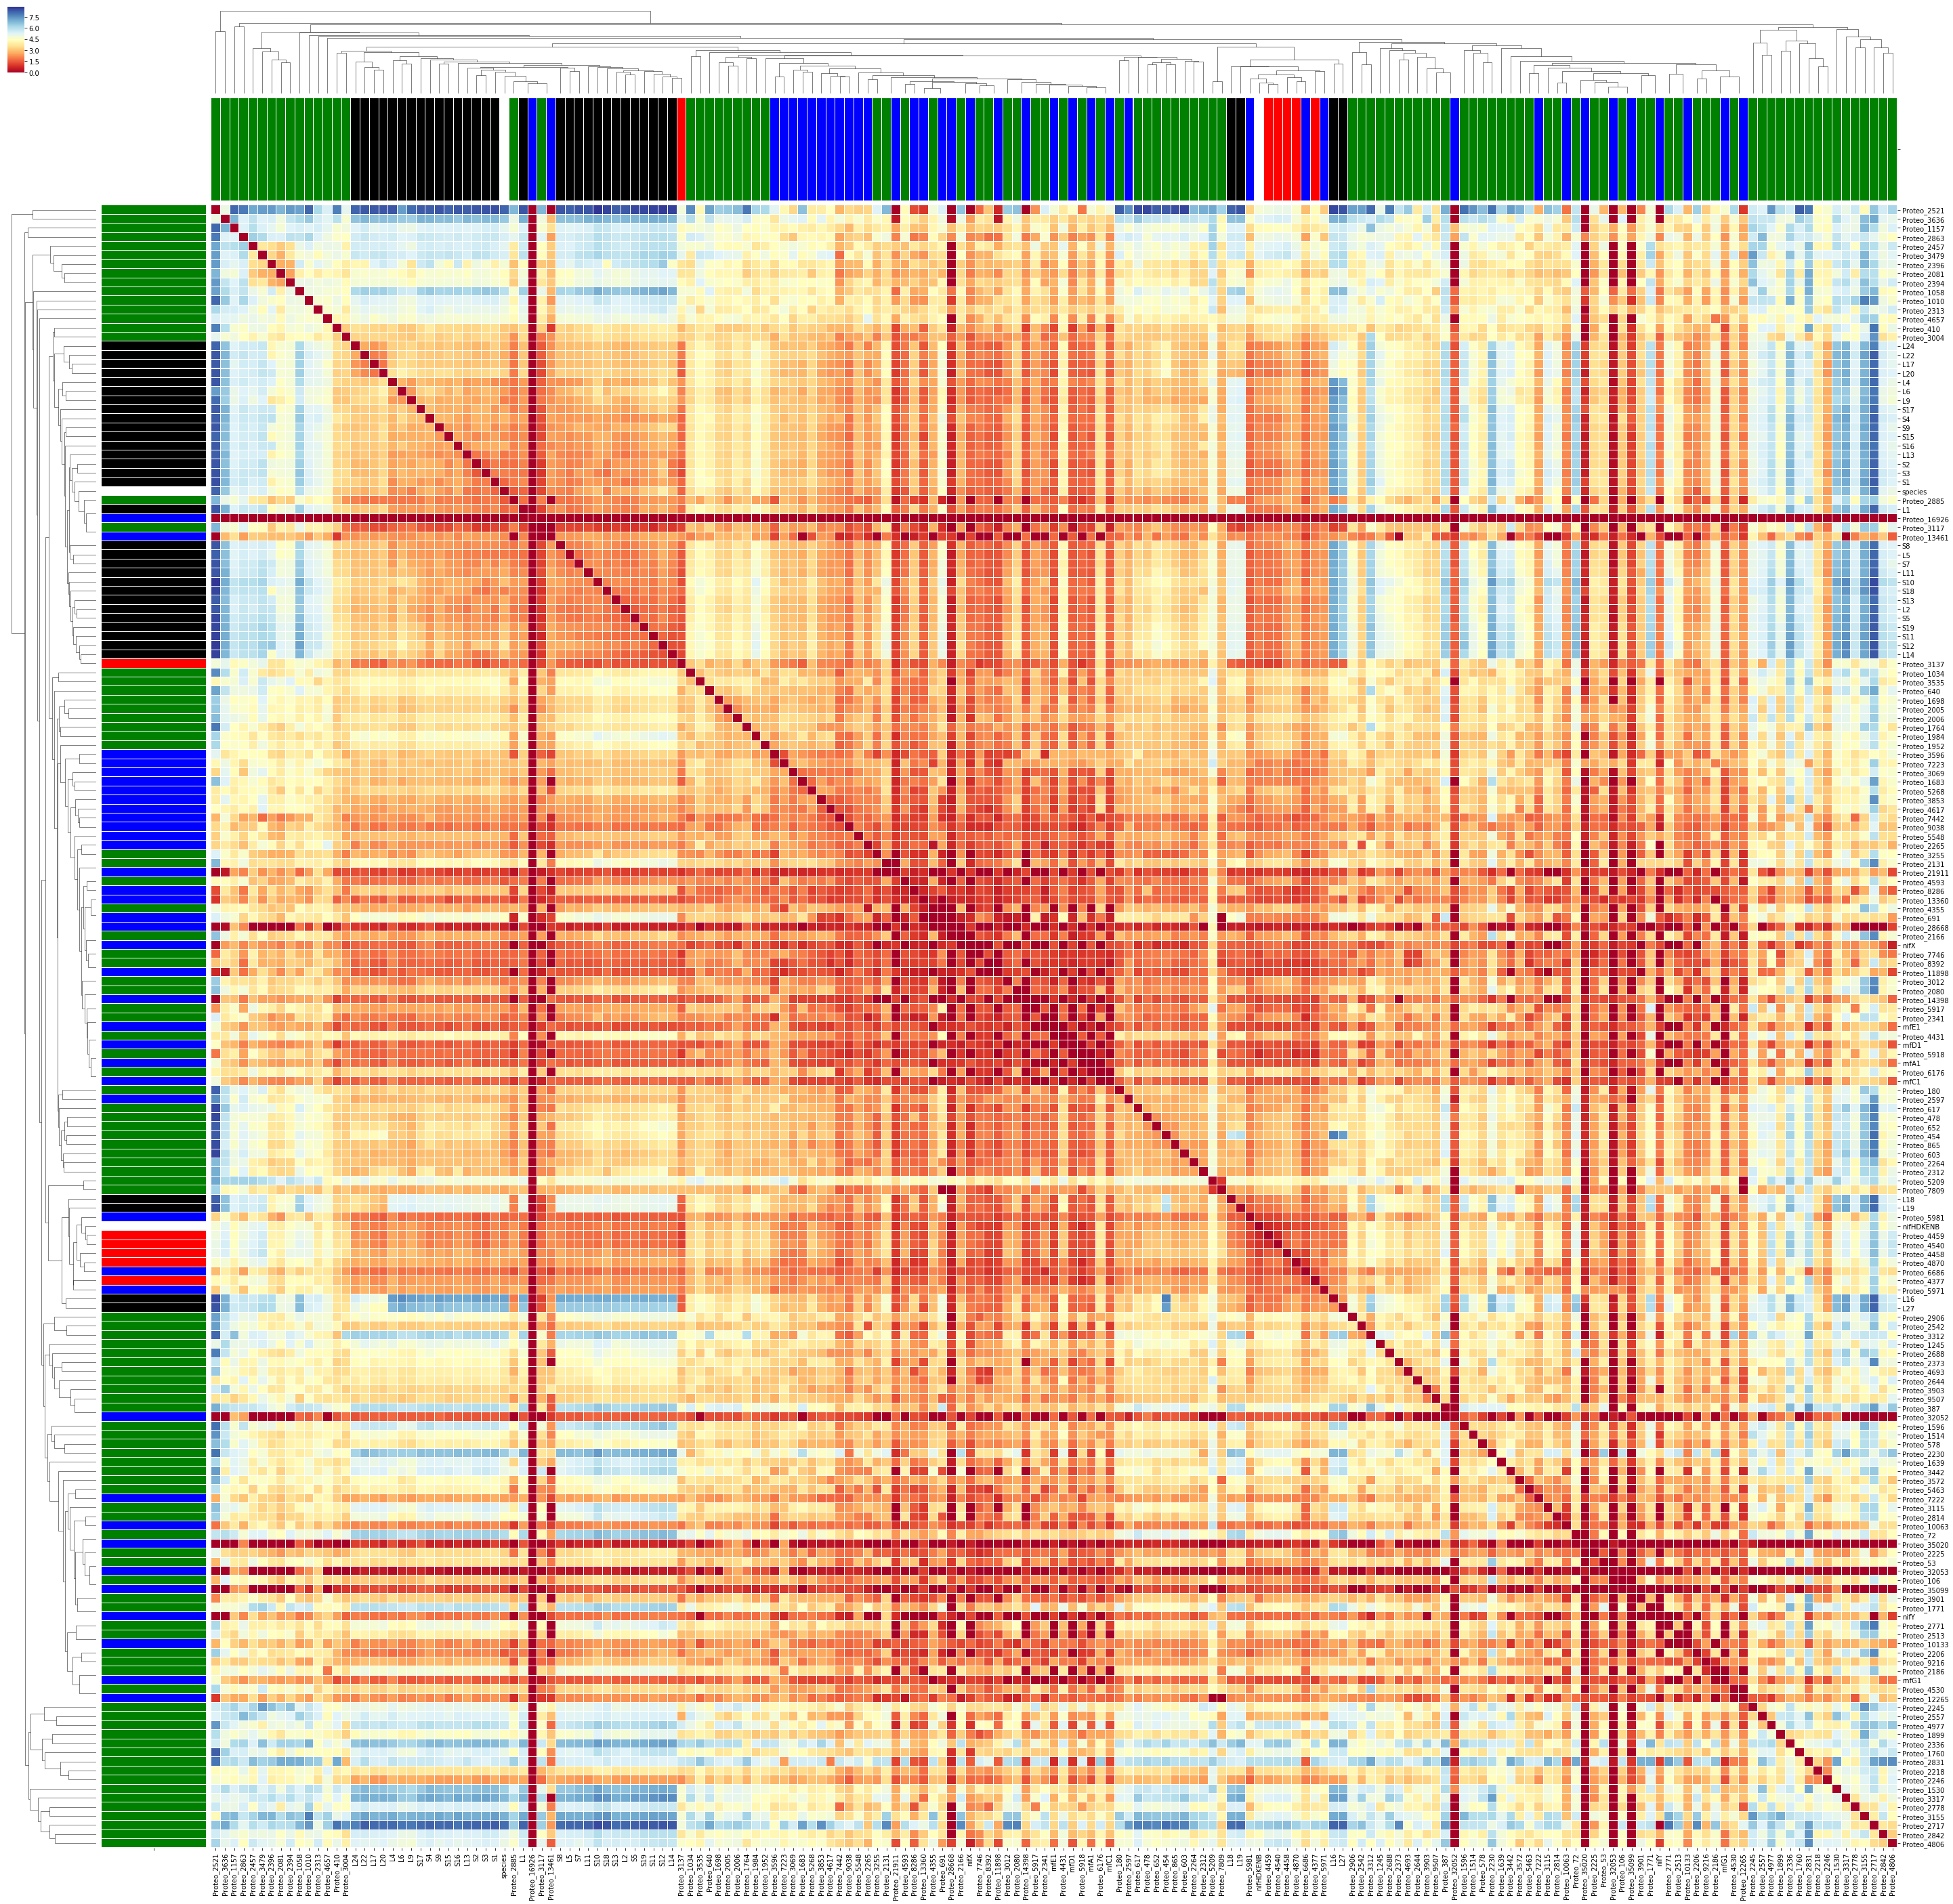

In [23]:
nifHDKENB = 'Proteo_3137 Proteo_4377 Proteo_4458 Proteo_4459 Proteo_4540 Proteo_4870'.split()
colors = {group:'r' for group in nifHDKENB}
colors.update({group:'b' for group in nif_genes.group.values if group not in nifHDKENB})
colors.update({group:'g' for group in groups})
colors.update({group:'k' for group in vertical_genes})
row_linkage = linkage(y=squareform(df.values), method='weighted')
sns.clustermap(df, row_linkage=row_linkage, col_linkage=row_linkage,
               figsize=(50,50), cmap='RdYlBu', linewidth=0.01,
               row_colors=pd.Series(colors), col_colors=pd.Series(colors))

In [26]:
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=12345)
coords    = embedding.fit_transform(df.values)
coords_df = pd.DataFrame(data=coords, columns='x y'.split(), index=df.index)

tmp = []
for group in df.index:
    if group in nifHDKENB or group == 'nifHDKENB':
        tmp.append('nif')
    elif group in nif_genes.group.values:
        tmp.append('nif related')
    elif group in groups:
        tmp.append('similarly distributed')
    elif group in vertical_genes or group == 'species':
        tmp.append('ribosomal')
    else:
        print 'weird...'
        
coords_df['gene_type'] = tmp

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.scatterplot(x='x', y='y', hue='gene_type',
                style='gene_type', data=coords_df,
                ax=ax, s=100, palette="Set2")

In [31]:
cmap        = plt.get_cmap('Set1')
color_range = ['#%02x%02x%02x' % cmap(value, bytes=True)[:3] for value in np.linspace(0, 1, 4)]
data        = []
for gene_type, color in zip(coords_df.gene_type.unique(), color_range):
    tmp    = coords_df[coords_df.gene_type == gene_type]
    
    data.append(
        go.Scatter(x=tmp.x.values, y=tmp.y.values, mode='markers', text=tmp.index,
               name=gene_type, hoverinfo='text', showlegend=False,
               marker=dict(size=10, color=color, opacity=.7,
                           symbol=['star' if index in ['species', 'nifHDKENB'] else 'circle'
                                   for index in tmp.index])
        )
    )
layout    = go.Layout(title='Geodesic distances', hovermode='closest', width=800, height=600,
#                      legend=dict(orientation='h'),
                     )
fig       = go.Figure(data=data, layout=layout)
ptl.iplot(fig, filename='tree_distances')